# Market Stress Indicators (Fast Signals)

We build **mechanism-aligned** market stress indicators:
- Volatility / uncertainty repricing (VIX + realized vol)
- Liquidity stress (volume anomalies)
- Diversification breakdown (cross-sectional correlation on a sector ETF panel)
- Disagreement / herding (cross-sectional dispersion on the same panel)
- Tail risk (rolling downside tail-event frequency with **no lookahead**)

**Scope:** indicators only (no composite index, no regimes, no performance claims).

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

from utils.io import load_parquet
from features.stress_volatility import compute_volatility_indicators
from features.stress_volume import compute_volume_stress
from features.stress_correlation import compute_correlation_stress
from features.stress_dispersion import compute_dispersion_stress
from features.stress_tails import compute_tail_stress

market = load_parquet("interim/market_daily.parquet")
print(market.index.min(), market.index.max())
assert market.index.min().year <= 2000
market.head()

2000-01-03 00:00:00 2025-12-15 00:00:00


,close_SPY,close_XLB,close_XLE,close_XLF,close_XLI,close_XLK,close_XLP,close_XLU,close_XLV,close_XLY,...,volume_XLB,volume_XLE,volume_XLF,volume_XLI,volume_XLK,volume_XLP,volume_XLU,volume_XLV,volume_XLY,vix_close
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,145.4375,12.984375,13.281250,18.582453,28.843750,27.718750,22.750000,13.726563,30.296875,15.062500,...,281000,760600,1185699,82800,1876200,634300,353400,246700,425800,24.209999
2000-01-04,139.7500,12.859375,13.031250,17.770105,28.046875,26.312500,22.109375,13.312500,29.609375,14.609375,...,516000,1444400,885705,146900,1091000,172000,187000,35300,354400,27.010000
2000-01-05,140.0000,13.390625,13.375000,17.630484,27.921875,25.921875,22.500000,13.648438,29.343750,14.429688,...,205400,675600,717181,129200,3812000,343600,546800,137600,249200,26.410000
2000-01-06,137.7500,13.734375,13.890625,18.404753,28.296875,25.062500,22.921875,13.625000,29.437500,14.593750,...,2670000,266200,415832,54000,3340000,420800,69000,50000,271600,25.730000
2000-01-07,145.7500,13.726563,14.039063,18.709383,29.375000,25.500000,24.375000,13.742188,29.796875,15.281250,...,1240200,936000,468149,32900,1372000,337100,92400,22100,140000,21.719999


## Build indicators

In [10]:
vol = compute_volatility_indicators(market, equity_ticker="SPY")
volu = compute_volume_stress(market, equity_ticker="SPY")
corr20 = compute_correlation_stress(market, window=20).reindex(market.index)
corr60 = compute_correlation_stress(market, window=60).reindex(market.index)
disp20 = compute_dispersion_stress(market, window=20)
disp60 = compute_dispersion_stress(market, window=60)
tail = compute_tail_stress(market, equity_ticker="SPY", window=252, q=0.05)

stress = pd.concat(
    [vol, volu,
     corr20.rename("avg_pairwise_corr_20"),
     corr60.rename("avg_pairwise_corr_60"),
     disp20.rename("xsec_dispersion_20"),
     disp60.rename("xsec_dispersion_60"),
     tail],
    axis=1
)

stress.tail()

,vix_level,vix_log_change,rv_20,rv_60,vol_log_ratio_20,vol_log_ratio_60,avg_pairwise_corr_20,avg_pairwise_corr_60,xsec_dispersion_20,xsec_dispersion_60,tail_freq_252_5
Date,,,,,,,,,,,
2025-12-08,16.66,0.077994,0.134849,0.122717,-0.339286,-0.307589,0.438603,0.373333,0.007254,0.007134,0.059524
2025-12-09,16.93,0.016077,0.124055,0.122373,-0.259156,-0.253347,0.431400,0.375362,0.007090,0.007092,0.059524
2025-12-10,15.77,-0.070978,0.125896,0.122921,0.070500,0.118610,0.445926,0.386037,0.006985,0.007056,0.059524
2025-12-11,14.85,-0.060110,0.126084,0.122900,0.064914,0.124457,0.453124,0.386641,0.007003,0.007118,0.059524
2025-12-15,16.50,0.105360,0.119260,0.125445,0.046473,0.106016,0.398049,0.375892,0.007314,0.007262,0.059524


## Quick sanity plots (not results)

We expect:
- VIX and realized vol to spike in known stress periods
- Correlations to rise during crises (diversification fails)
- Dispersion to rise during dislocation/rotation
- Tail frequency to increase in extended turbulent periods

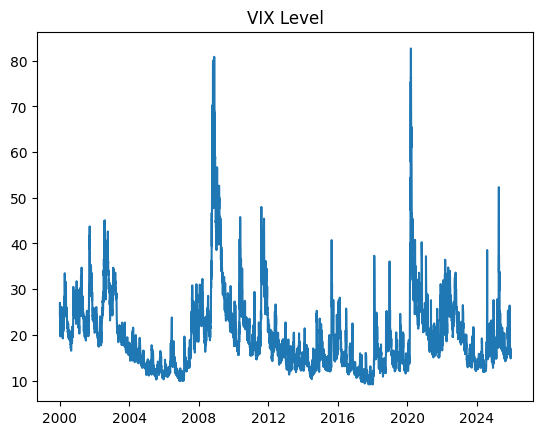

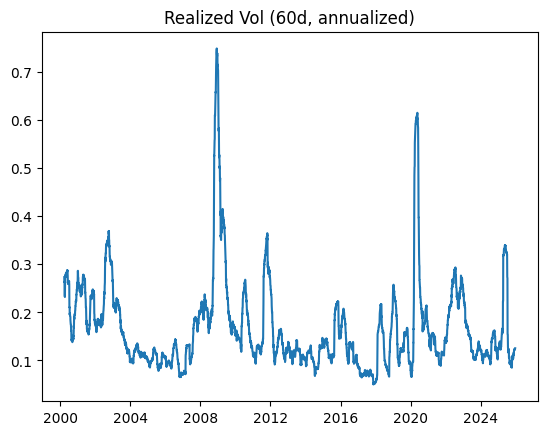

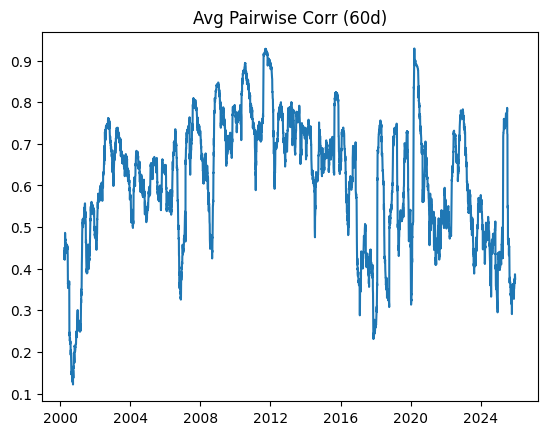

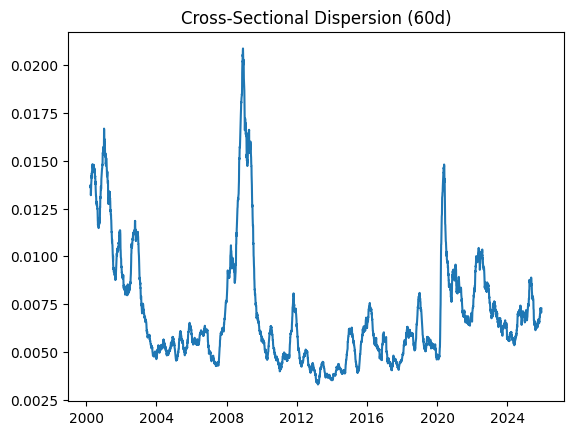

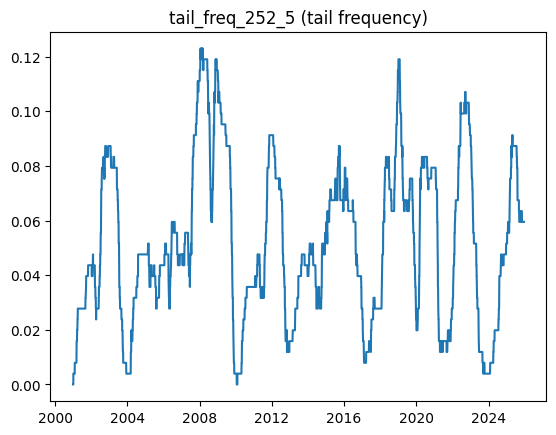

In [11]:
def plot_series(s, title):
    plt.figure()
    plt.plot(s.index, s.values)
    plt.title(title)
    plt.show()

plot_series(stress["vix_level"], "VIX Level")
plot_series(stress["rv_60"], "Realized Vol (60d, annualized)")
plot_series(stress["avg_pairwise_corr_60"], "Avg Pairwise Corr (60d)")
plot_series(stress["xsec_dispersion_60"], "Cross-Sectional Dispersion (60d)")
plot_series(stress[stress.columns[-1]], f"{stress.columns[-1]} (tail frequency)")